# Reactor Schedule
24/05/24
Initial Conditions added. Make sure at least 1 reactor is on initially.
Extended Outage added.

28/05/24 Permutations added: shutting off reactors, shutting off reactors AND extending the next on cycle

In [28]:
from gurobipy import *
import numpy as np
import seaborn as sns 
import pandas as pd
import matplotlib.pyplot as plt 
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from itertools import product

In [130]:
def tupledict_to_dataframe(tupledict):
    # Get all unique keys from the tuples
    all_row_keys = set()
    all_col_keys = set()
    for row_key, col_key in tupledict.keys():
        all_row_keys.add(row_key)
        all_col_keys.add(col_key)

    # Initialize the table as a dictionary of dictionaries
    table = {}
    for row_key in all_row_keys:
        table[row_key] = {}
        for col_key in all_col_keys:
            table[row_key][col_key] = None

    # Populate the table
    for (row_key, col_key), value in tupledict.items():
        table[row_key][col_key] = value

    # Convert the table dictionary to a DataFrame
    df = pd.DataFrame.from_dict(table, orient='index')

    # Rename the index and columns
    df.index.name = 'Row'
    df.columns.name = 'Column'

    return df

In [852]:
# reactors = ['BR2',
#             'HFR',
#             'LVR',
#             'MARIA',
#             'OPAL',
#             'SAFARI']
reactors = [0, 1, 2, 3, 4, 5]
dict_1 = {'production cycles min': [3, 3, 2, 2, 2, 2],
          'production cycles max': [9, 6, 10, 8, 8, 8],
          'cycle length min': [2, 2, 1, 3, 2, 2],
          'cycle length max': [10, 16, 4, 8, 10, 10],
          'planned outages': [3, 3, 2, 1, 2, 2], 
          'outage duration min': [4, 4, 6, 10, 5, 3],
          'extended outage duration min': [8, 6, 6, 20, 8, 8]}
rdata = {'Capacity': [8600, 6200, 3000, 2200, 3200, 3000]}
reactordf1 = pd.DataFrame(rdata, index=reactors)
dfdf = pd.DataFrame(dict_1, index=reactors)
R = len(reactors)
T_i = [1, 1, 1, 1, 1, 1] # period until reactor will be in initial state (so 1 means up to 1. so period 0 only)
y_i = [1, 0, 0, 0, 0, 1] # initial state of reactor

# time range of when a reactor can start an extended outage
T_e = [[10,30],
       [10,14],
       [15,19],
       [20,40],
       [26,30],
       [35,40]]

# number of reactors on and off at a time
dict_2 = {'min': 1,
         'max':4}
dfdf2 = pd.DataFrame(dict_2, index=['reactors on'])

# processors = ['IRE',
#               'Curium',
#               'ANSTO',
#               'NTP']
processors = [0,1,2,3]
pdata = {'Capacity': [3500, 5000, 3200, 3000]}
pdf = pd.DataFrame(pdata, index=processors)
P = len(processors)

# markets = ['US',
#            'EU',
#            'AS',
#            'AU',
#            'AF']
markets = [0,1,2,3,4]
mdata = {'Demand': [5200, 3000, 500, 1000, 300],
         'Capacity': [10400, 6000, 1000, 2000, 600],
         'Reward': [5, 3, 1, 1, 1],
         'Penalty': [-7, -4, -2, -2, -2]}
mdf = pd.DataFrame(mdata, index=markets)
M = len(markets)

# time horizon
T = 52
RT = list(product(range(R), range(T)))

e_e_ranges = []
for r in range(R):
    for i in range(T_e[r][0], T_e[r][1]+1):
        e_e_ranges.append((r,i))

# reactor to prodocessor decay factor
rp = np.array(
    [[0.95, 0.98, 0, 0],
      [0.98, 0.95, 0, 0],
      [0.7, 0.74, 0, 0],
      [0.66, 0.65, 0, 0],
      [0, 0, 0.95, 0],
      [0, 0, 0, 0.95]]
)

# processor to market decay factor
pm = np.array(
    [[0.6, 0.9, 0.5, 0.45, 0.6],
      [0.6, 0.9, 0.5, 0.45, 0.6],
      [0.7, 0.6, 0.8, 0.6, 0.5],
      [0.5, 0.6, 0.5, 0.6, 0.9]]
)
    
[row, col] = np.shape(rp)
rpdict = {}
for r in range(row):
    for c in range(col):
        rpdict[(r, c)] = rp[r, c]

[row, col] = np.shape(pm)
pmdict = {}
for r in range(row):
    for c in range(col):
        pmdict[(r, c)] = pm[r, c]

surpluscap = mdf['Capacity'] - mdf['Demand']

s_min = dfdf['production cycles min'].tolist()     #min number of times reactor r can start production
s_max = dfdf['production cycles max'].tolist()       #max number of times reactor r can start production
l_min = dfdf['cycle length min'].tolist()        #min duration of production runs of reactor r
l_max = dfdf['cycle length max'].tolist()          #max duration of production runs of reactor r
b_min = dfdf['planned outages'].tolist()         #min number of outtages for reactor r
q_min = dfdf['outage duration min'].tolist()         #min duration of an outtage for reactor r
qe_min = dfdf['extended outage duration min'].tolist()         #min duration of an outtage for reactor r

## Stage 1

In [855]:
def plot_schedule(schedule):
    binary_data = schedule.applymap(lambda x: 1 if x != 0 else 0)
    # Plotting
    fig, ax = plt.subplots(figsize=(15, 2))
    
    # Iterate through each row and plot horizontal bars for 1s
    for i, (row_label, row_data) in enumerate(binary_data.iterrows()):
        for j, value in enumerate(row_data):
            if value == 1:
                ax.barh(i, 1, left=j, color=sns.color_palette("colorblind")[i])
    
    # Set y ticks and labels
    ax.set_yticks(range(len(binary_data)))
    ax.set_yticklabels(binary_data.index)
    
    # Set x ticks and labels
    ax.set_xticks(np.arange(0.5, len(binary_data.columns) + 0.5, 1))
    ax.set_xticklabels(binary_data.columns)
    plt.xlim(0,T)
    
    # Set labels and title
    ax.set_ylabel('Reactor')
    ax.set_xlabel('Week')
    plt.title('Reactor Schedule')
    
    # Invert y-axis to have the first task at the top
    plt.gca().invert_yaxis()
    
    # Remove spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

In [868]:
#Model
m = Model()
m.ModelSense = GRB.MAXIMIZE

#Decision Variables
y = m.addVars(RT, vtype=GRB.BINARY, name='y')
v = m.addVars(RT, vtype=GRB.BINARY, name='v')
e = m.addVars(RT, vtype=GRB.BINARY, name='e')
e_e = m.addVars(e_e_ranges, vtype=GRB.BINARY, name='e_e')

#Objective Function
m.setObjective(quicksum(y[(r,t)] for r in range(R) for t in range(T))/T)

#Constraints
for t in range(T):
    # one reactor always on
    m.addConstr(quicksum(y[(r,t)] for r in range(R)) >= dfdf2['min'][0])
    # no more than 3 reactors on at a time
    m.addConstr(quicksum(y[(r,t)] for r in range(R)) <= dfdf2['max'][0])
    # Start-Up Auxulliary Constraint
    if t==0:
        m.addConstrs(v[(r,t)] >= y[(r,t)] - 0 for r in range(R))
    else:
        m.addConstrs(v[(r,t)] >= y[(r,t)] - y[(r,t-1)] for r in range(R))

for r in range(R):
    # Initial Conditions Set
    m.addConstrs(y[(r,t)] == y_i[r] for t in range(T_i[r]))
    # Initial Conditions Start Up Status
    m.addConstr(v[(r,0)] == y_i[r])
    # Initial Conditions Shut Down Status
    m.addConstr(e[(r,0)] == 1 - y_i[r])
    
    # Amount of On-Cycles Constraint
    m.addConstr(quicksum(v[(r,t)] for t in range(T)) >= s_min[r])
    m.addConstr(quicksum(v[(r,t)] for t in range(T)) <= s_max[r])

    # Amount of Off-Cycles Constraint
    m.addConstr(quicksum(e[(r,t)] for t in range(T)) >= b_min[r])

    # Extended Outage Exists
    m.addConstr(quicksum(v[(r,t)] for t in range(T_e[r][0], T_e[r][1]+1)) == 1)
    for t in np.intersect1d(range(T_e[r][0]+qe_min[r]-1, T_e[r][1]+qe_min[r]+1), range(T)):
        # Extended Outage Minimum Duration
        m.addConstr(quicksum(e_e[(r,i)] for i in np.intersect1d(range(T_e[r][0], T_e[r][1]+1), range(t-qe_min[r]+1, t+1))) <= 1 - y[(r,t)])
    for t in range(T_e[r][0], T_e[r][1]+1):    
        # Extended Outage Auxiliary
        m.addConstr(e_e[(r, t)] >= y[(r,t-1)] - y[(r,t)])
    
    
    for t in range(l_min[r]-1,T):
        # Minimum Duration Constraint
        m.addConstr(quicksum(v[(r,i)] for i in range(t-l_min[r]+1,t+1)) <= y[(r,t)])
    for t in range(l_max[r],T):
        # Maxinum Duration Constraint
        m.addConstr(quicksum(y[(r,i)] for i in range(t-l_max[r],t+1)) <= l_max[r])
    for t in range(q_min[r]-1,T):
        # Minimum Duration of Outtage Constraint
        m.addConstr(quicksum(e[(r,i)] for i in range(t-q_min[r]+1,t+1)) <= 1 - y[(r,t)])    
    for t in range(1,T):
            # Shut Down Auxiliary Constraint
            m.addConstr(e[(r,t)] >= y[(r,t-1)] - y[(r,t)])
            # Start Up and Shut Down Test in Python
            m.addConstr(y[(r,t)] - y[(r,t-1)] == v[(r,t)] - e[(r,t)])
        
m.update()
m.optimize()

solution_1_1 = m.getAttr('X', y)
solution_1_2 = m.getAttr('X', v)
solution_1_3 = m.getAttr('X', e)

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: Intel(R) Xeon(R) Gold 6330 CPU @ 2.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 56 physical cores, 112 logical processors, using up to 32 threads

Optimize a model with 2033 rows, 999 columns and 10629 nonzeros
Model fingerprint: 0xfeca7169
Variable types: 0 continuous, 999 integer (999 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-02, 2e-02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Presolve removed 772 rows and 112 columns
Presolve time: 0.06s
Presolved: 1261 rows, 887 columns, 7744 nonzeros
Variable types: 0 continuous, 887 integer (887 binary)
Found heuristic solution: objective 2.4615385

Root relaxation: objective 3.826923e+00, 828 iterations, 0.05 seconds (0.03 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

    

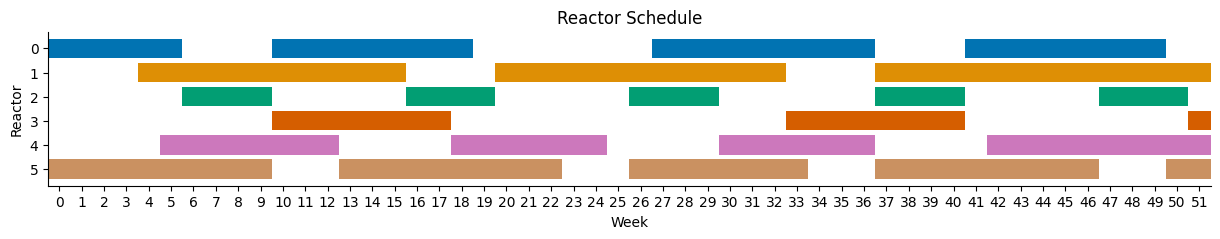

In [869]:
stage1_y = tupledict_to_dataframe(solution_1_1)
stage1_v = tupledict_to_dataframe(solution_1_2)
stage1_e = tupledict_to_dataframe(solution_1_3)
slice1 = stage1_y 
plot_schedule(slice1)

In [870]:
test = np.where(stage1_v.iloc[5] == 1)[0]
np.where(stage1_v.iloc[5] == 1)[0]
np.where(stage1_e.iloc[5] == 1)[0]
stage1_e

Column,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,50,51
Row,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,1.0,0.0,-0.0,0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,1.0,-0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
5,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,...,0.0,-0.0,-0.0,-0.0,-0.0,1.0,0.0,-0.0,-0.0,-0.0


In [872]:
m.getAttr('X', e_e)

{(0, 10): -0.0,
 (0, 11): -0.0,
 (0, 12): -0.0,
 (0, 13): -0.0,
 (0, 14): -0.0,
 (0, 15): -0.0,
 (0, 16): -0.0,
 (0, 17): -0.0,
 (0, 18): -0.0,
 (0, 19): 1.0,
 (0, 20): -0.0,
 (0, 21): 0.0,
 (0, 22): -0.0,
 (0, 23): -0.0,
 (0, 24): -0.0,
 (0, 25): -0.0,
 (0, 26): -0.0,
 (0, 27): -0.0,
 (0, 28): -0.0,
 (0, 29): -0.0,
 (0, 30): -0.0,
 (1, 10): 0.0,
 (1, 11): 0.0,
 (1, 12): 0.0,
 (1, 13): 0.0,
 (1, 14): 0.0,
 (2, 15): 1.0,
 (2, 16): 0.0,
 (2, 17): 0.0,
 (2, 18): 0.0,
 (2, 19): 0.0,
 (3, 20): 0.0,
 (3, 21): -0.0,
 (3, 22): -0.0,
 (3, 23): -0.0,
 (3, 24): -0.0,
 (3, 25): -0.0,
 (3, 26): -0.0,
 (3, 27): -0.0,
 (3, 28): -0.0,
 (3, 29): -0.0,
 (3, 30): -0.0,
 (3, 31): -0.0,
 (3, 32): -0.0,
 (3, 33): -0.0,
 (3, 34): -0.0,
 (3, 35): -0.0,
 (3, 36): -0.0,
 (3, 37): -0.0,
 (3, 38): -0.0,
 (3, 39): -0.0,
 (3, 40): -0.0,
 (4, 26): 0.0,
 (4, 27): 0.0,
 (4, 28): 0.0,
 (4, 29): 0.0,
 (4, 30): 0.0,
 (5, 35): 0.0,
 (5, 36): 0.0,
 (5, 37): 0.0,
 (5, 38): 0.0,
 (5, 39): 0.0,
 (5, 40): 0.0}

## Schedule Permutations

[0 0 0 0]
[0 0 0 0]
[0 0 0 0 0 0]
[0 0 0 0]
[0 0 0]
[0 0 0 0 1]


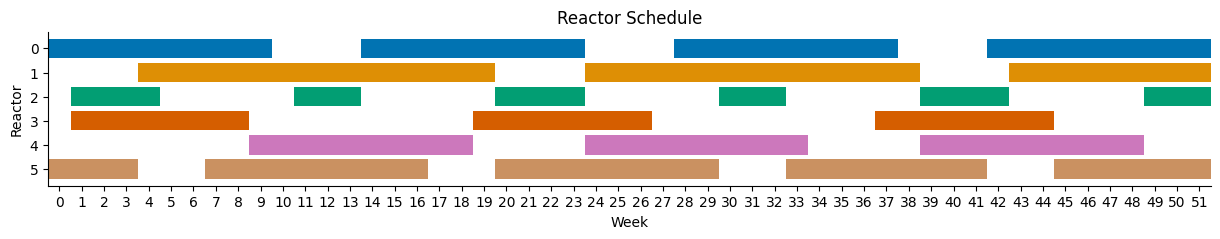

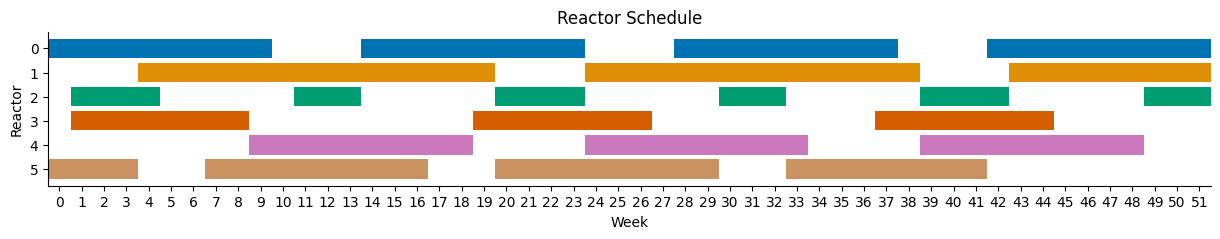

In [835]:
# probability reactor r does not run at all
shutdown_p = [.03,
              .03,
              .03,
              .03,
              .03,
              .03]
on_cycles = stage1_v.sum(axis=1).values
# ONE SHUTDOWN PER PERIOD
new_sched = stage1_y.copy()
plot_schedule(new_sched)
for r in range(R):
    iter = np.random.rand(int(on_cycles[r]))
    # if that cycle will be a random shutdown or not
    if_shutdown = np.where(iter <= shutdown_p[r], 1, 0)
    print(if_shutdown)
    # tracks which cycle is shutdown
    cycle_num = np.where(if_shutdown == 1)[0].tolist()

    if len(cycle_num) > 0: # if there are cycle_num to shut off
        cycle_off = cycle_num[0] # only shutsdown the first one, no repeat shutdowns YET
        # period where on cycle starts
        cycle_start = np.where(stage1_v.iloc[r] == 1)[0][cycle_off]
        if cycle_off < len(if_shutdown)-1: # turn off until start of next cycle
            # period before next cycle starts
            cycle_end = np.where(stage1_v.iloc[r] == 1)[0][cycle_off+1]
            new_sched.iloc[[r], cycle_start:cycle_end] = 0
        else: # turn off until end of time horizon
            new_sched.iloc[[r], cycle_start:T] = 0
plot_schedule(new_sched)

[0 0 0 0]
[0 0 0 0]
[0 0 1 0 0 0]
[0 1 1 1]
[0 0 1]
[0 0 0 0 0]


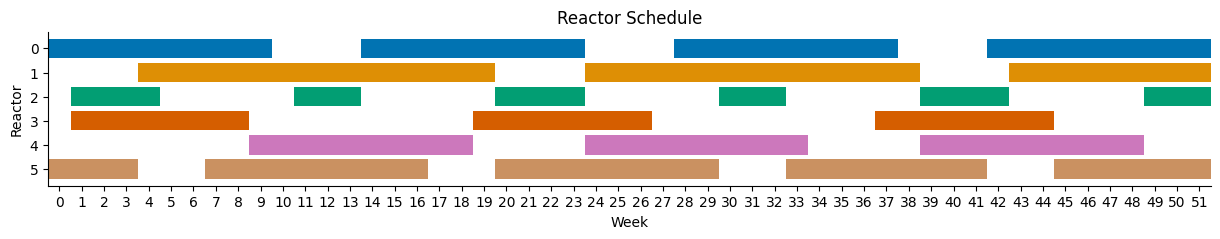

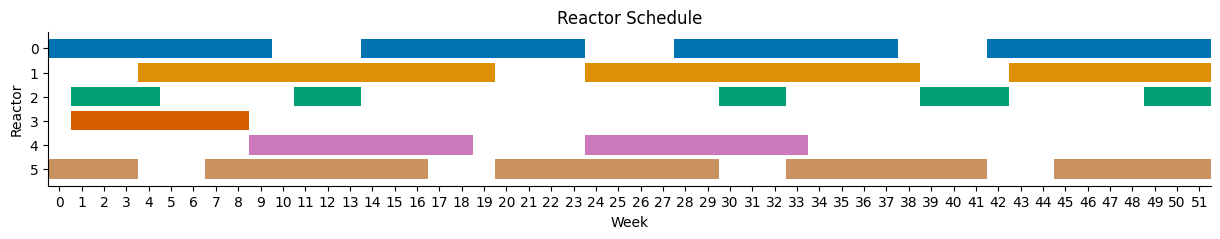

In [837]:
# probability reactor r does not run at all
shutdown_p = [.03,
              .03,
              .03,
              .3,
              .03,
              .03]
on_cycles = stage1_v.sum(axis=1).values
# AS MANY SHUTDOWNS AS RNGESUS WANTS
new_sched = stage1_y.copy()
plot_schedule(new_sched)
for r in range(R):
    iter = np.random.rand(int(on_cycles[r]))
    # if that cycle will be a random shutdown or not
    if_shutdown = np.where(iter <= shutdown_p[r], 1, 0)
    print(if_shutdown)
    # tracks which cycle is shutdown
    cycle_num = np.where(if_shutdown == 1)[0].tolist()

    if len(cycle_num) > 0: # if there are cycle_num to shut off
        for cycle_off in cycle_num:
            # period where on cycle starts
            cycle_start = np.where(stage1_v.iloc[r] == 1)[0][cycle_off]
            if cycle_off < len(if_shutdown)-1: # turn off until start of next cycle
                # period before next cycle starts
                cycle_end = np.where(stage1_v.iloc[r] == 1)[0][cycle_off+1]
                new_sched.iloc[[r], cycle_start:cycle_end] = 0
            else: # turn off until end of time horizon
                new_sched.iloc[[r], cycle_start:T] = 0
plot_schedule(new_sched)

[0 0 0 0 0]
[0 0 0 0]
[0 0 0 0 0]
[0 0 0 0]
[0 0 0 0 0]
[0 0 0 0]


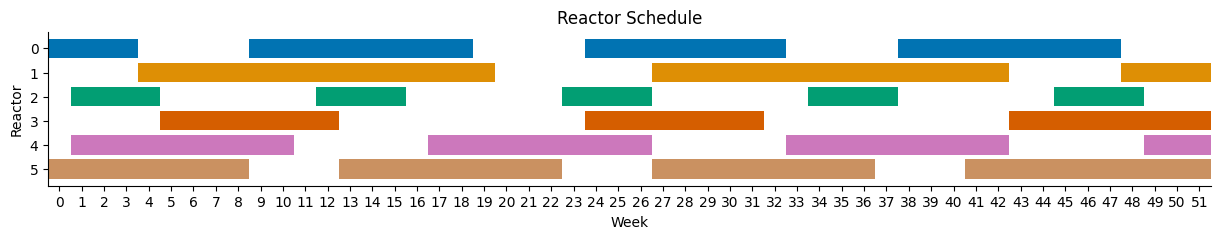

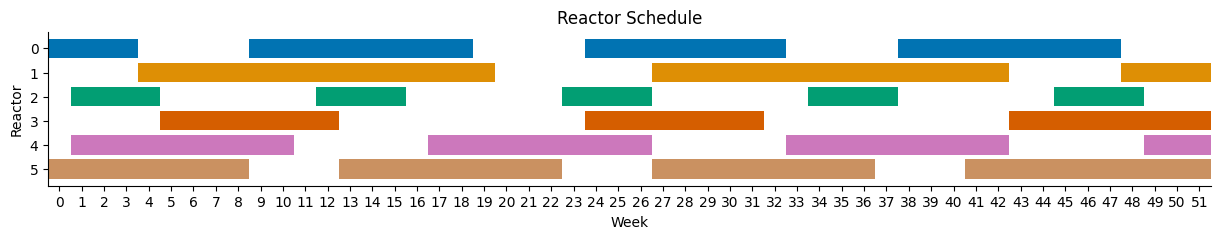

In [824]:
# probability reactor r does not run at all
shutdown_p = [.03,
              .03,
              .03,
              .03,
              .03,
              .03]
on_cycles = stage1_v.sum(axis=1).values
# ONE SHUTDOWN PER PERIOD and next cycle is extended forward as much as possible
new_sched = stage1_y.copy()
new_ups = stage1_v.copy()
plot_schedule(new_sched)
for r in range(R):
    iter = np.random.rand(int(on_cycles[r]))
    # if that cycle will be a random shutdown or not
    if_shutdown = np.where(iter <= shutdown_p[r], 1, 0)
    print(if_shutdown)
    # tracks which cycle is shutdown
    cycle_num = np.where(if_shutdown == 1)[0].tolist()

    if len(cycle_num) > 0: # if there are cycle_num to shut off
        cycle_off = cycle_num[0] # only shutsdown the first one, no repeat shutdowns YET
        # period where on cycle starts
        cycle_start = np.where(stage1_v.iloc[r] == 1)[0][cycle_off]
        if cycle_off < len(if_shutdown)-1: # if not last cycle of the horizon
            # period before next cycle starts 
            cycle_end = np.where(stage1_v.iloc[r] == 1)[0] 
            # turn off until start of next cycle
            new_sched.iloc[[r], cycle_start:cycle_end] = 0
            # if its the second last on cycle
            if cycle_off == len(if_shutdown)-2:
                time_range = new_sched.iloc[[r], cycle_end:T]
                duration = int(time_range.sum(axis=1)[r])
                print(new_sched.iloc[[r], cycle_end-(l_max[r]-duration):cycle_end])
                new_sched.iloc[[r], cycle_end-(l_max[r]-duration):cycle_end] = 1
                new_ups.iloc[r, cycle_end-(l_max[r]-duration)] = 1
                new_ups.iloc[r, cycle_end] = 0
                print(new_sched.iloc[[r], cycle_end-(l_max[r]-duration):cycle_end])
            else:
                cycle_end2 = np.where(stage1_v.iloc[r] == 1)[0][cycle_off+2]
                time_range = new_sched.iloc[[r], cycle_end:cycle_end2]
                duration = int(time_range.sum(axis=1)[r])
                print(new_sched.iloc[[r], cycle_end-(l_max[r]-duration):cycle_end])
                new_sched.iloc[[r], cycle_end-(l_max[r]-duration):cycle_end] = 1
                print(new_sched.iloc[[r], cycle_end-(l_max[r]-duration):cycle_end])
            
        else: # turn off until end of time horizon
            new_sched.iloc[[r], cycle_start:T] = 0
plot_schedule(new_sched)

In [823]:
test = np.where(stage1_v.iloc[5] == 1)[0]
np.where(stage1_v.iloc[5] == 1)[0]
np.where(stage1_e.iloc[5] == 1)[0]
stage1_e

Column,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,50,51
Row,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,-0.0,1.0,0.0,-0.0,-0.0,-0.0,-0.0,...,0.0,-0.0,-0.0,0.0,-0.0,-0.0,1.0,-0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,1.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,1.0
2,0.0,0.0,0.0,-0.0,0.0,1.0,-0.0,0.0,-0.0,-0.0,...,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,1.0,0.0,-0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,...,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,...,0.0,1.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,1.0
5,0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,1.0,...,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0


[0 0 0 1 0]
Column   41   42   43   44   45   46   47   48   49   50
Row                                                     
0       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
Column   41   42   43   44   45   46   47   48   49   50
Row                                                     
0       1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
[0 0 0 0]
[0 0 0 0 0]
[0 0 0 0]
[0 0 0 0 0]
[0 0 0 0]


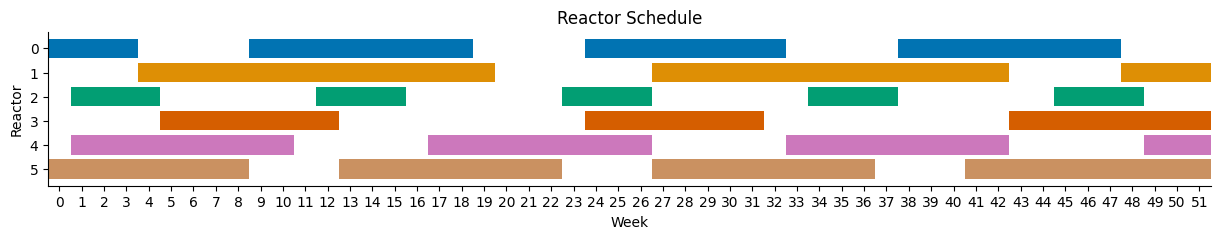

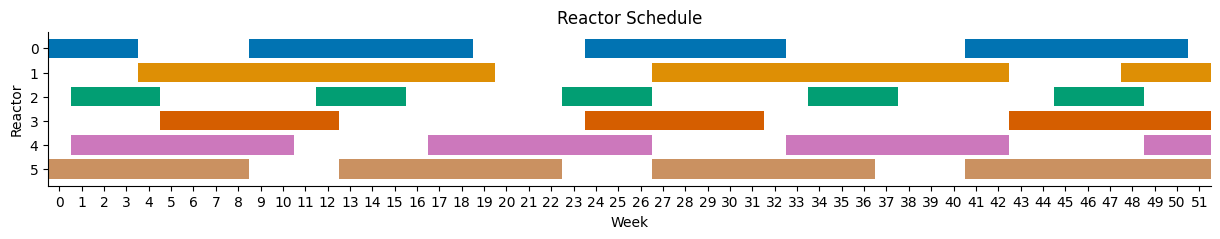

In [812]:
# probability reactor r does not run at all
shutdown_p = [.03,
              .03,
              .03,
              .03,
              .03,
              .03]
on_cycles = stage1_v.sum(axis=1).values
# SHUTDOWN AS MANY AS YOU WANT next cycle is extended forward as much as possible
new_sched = stage1_y.copy()
plot_schedule(new_sched)
for r in range(R):
    iter = np.random.rand(int(on_cycles[r]))
    # if that cycle will be a random shutdown or not
    if_shutdown = np.where(iter <= shutdown_p[r], 1, 0)
    print(if_shutdown)
    # tracks which cycle is shutdown
    cycle_num = np.where(if_shutdown == 1)[0].tolist()

    if len(cycle_num) > 0: # if there are cycle_num to shut off
        start_times = np.where(stage1_v.iloc[r] == 1)[0]
        for cycle_off in cycle_num:
            # period where on cycle starts
            cycle_start = start_times[cycle_off]
            if cycle_off < len(if_shutdown)-1: # if not last cycle of the horizon
                # period before next cycle starts 
                cycle_end = start_times[cycle_off+1]
                # turn off until start of next cycle
                new_sched.iloc[[r], cycle_start:cycle_end] = 0
                # if its the second last on cycle
                if cycle_off == len(if_shutdown)-2:
                    time_range = new_sched.iloc[[r], cycle_end:T]
                    duration = int(time_range.sum(axis=1)[r])
                    print(new_sched.iloc[[r], cycle_end-(l_max[r]-duration):cycle_end])
                    new_sched.iloc[[r], cycle_end-(l_max[r]-duration):cycle_end] = 1
                    start_times[cycle_off] = cycle_end-(l_max[r]-duration)
                    print(new_sched.iloc[[r], cycle_end-(l_max[r]-duration):cycle_end])
                else:
                    cycle_end2 = np.where(stage1_v.iloc[r] == 1)[0][cycle_off+2]
                    time_range = new_sched.iloc[[r], cycle_end:cycle_end2]
                    duration = int(time_range.sum(axis=1)[r])
                    print(new_sched.iloc[[r], cycle_end-(l_max[r]-duration):cycle_end])
                    new_sched.iloc[[r], cycle_end-(l_max[r]-duration):cycle_end] = 1
                    start_times[cycle_off] = cycle_end-(l_max[r]-duration)
                    print(new_sched.iloc[[r], cycle_end-(l_max[r]-duration):cycle_end])
                
            else: # turn off until end of time horizon
                new_sched.iloc[[r], cycle_start:T] = 0
plot_schedule(new_sched)

In [763]:
cycle_start

28

In [741]:
new_sched.iloc[[5], 45:45]

Column
Row
5


In [734]:
duration

4.0

In [713]:
np.where(stage1_e.iloc[4] == 1)[0]

array([ 0, 10, 20, 30, 40])

## Stage 2

In [270]:
# reactor capacity in a schedule
reactordf = df.multiply(rdata.get('Capacity'), axis="index")

market = np.zeros((T, M))
for count in range(T):
    rdf = pd.DataFrame({'Capacity': reactordf[count]}, index=reactors)
    mm = Model()
    mm.reset()
    mm.Params.Presolve = 0
    p = mm.presolve()
    p.printStats()
    mm.ModelSense = GRB.MAXIMIZE
    
    # VARIABLES
    # reactor to processors
    x_rp = mm.addVars(R, P, lb=0, name='x_rp')

     # processor to markets
    x_pm = mm.addVars(P, M, lb=0, name='x_pm')

    # market shortage and surplus
    shortage = mm.addVars(M, lb=0, ub=mdf['Demand'].values, name='shortage')
    surplus = mm.addVars(M, lb=0, ub=surpluscap.values, name='surplus')

    # how much a market uses
    x_m = mm.addVars(M, lb=0, ub=mdf['Capacity'].values, name='uses')

    # OBJECTIVE
    mm.setObjective(sum((surplus[m]*mdf['Reward'][m] + shortage[m]*mdf['Penalty'][m])/mdf['Demand'][m] for m in range(M)))

    # CONSTRAINTS
    # reactor capacity
    mm.addConstrs((x_rp.sum(r, '*') <= rdf['Capacity'][r] for r in range(R)), name='reactor capacity')

    # processor capacity
    mm.addConstrs((x_pm.sum(p, '*') <= pdf['Capacity'][p] for p in range(P)), name='processor capacity')

    # market capacity
    mm.addConstrs((x_m[m] - surplus[m] + shortage[m] == mdf['Demand'][m] for m in range(M)))
    mm.addConstrs((x_m[m] - surplus[m] <= mdf['Demand'][m] for m in range(M)))
    mm.addConstrs((x_m[m] + shortage[m] >= mdf['Demand'][m] for m in range(M)))

    # processor balance 
    mm.addConstrs((x_pm.sum(p, '*') <= x_rp.prod(rpdict, '*', p) for p in range(P)), name='processor balance')

    # market balance
    #m.addConstrs((mdf['Demand'][m] - shortage[m] + surplus[m] <= x_pm.prod(pmdict, '*', m) for m in range(M)), name='market balance')
    mm.addConstrs((x_m[m] <= x_pm.prod(pmdict, '*', m) for m in range(M)), name='market balance')

    mm.update()
    mm.optimize()
    market[count] = np.array(mm.getAttr('X', x_m).select())

dffig1 = pd.DataFrame(market, columns=markets)
plswork = df._append(dffig1.T)

Discarded solution information
Set parameter Presolve to value 0

Statistics for modelPresolved:
  Linear constraint matrix    : 0 Constrs, 0 Vars, 0 NZs
  Matrix coefficient range    : [ 0, 0 ]
  Objective coefficient range : [ 0, 0 ]
  Variable bound range        : [ 0, 0 ]
  RHS coefficient range       : [ 0, 0 ]
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: Intel(R) Xeon(R) Gold 6330 CPU @ 2.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 56 physical cores, 112 logical processors, using up to 32 threads

Optimize a model with 34 rows, 59 columns and 134 nonzeros
Model fingerprint: 0x00e1bc54
Coefficient statistics:
  Matrix range     [5e-01, 1e+00]
  Objective range  [1e-03, 7e-03]
  Bounds range     [3e+02, 1e+04]
  RHS range        [3e+02, 9e+03]
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.1000000e+01   2.500000e+03   0.000000e+00      0s
      21   -1.8602198e+00   0.000000e+00   0.000000e+00      0s

Solved 

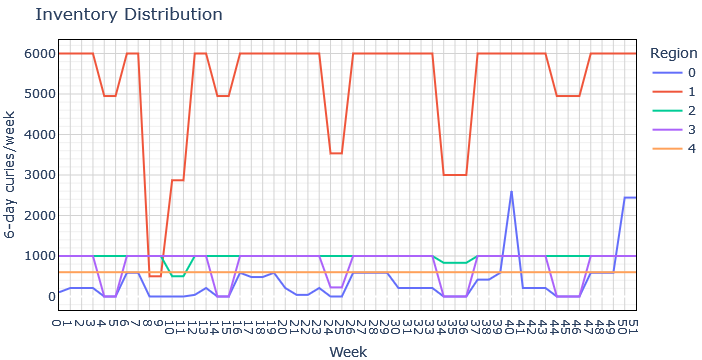

In [271]:
slice2 = plswork._slice(slice(6,12)).T
fig2 = px.line(slice2)

fig2.update_layout(title="Inventory Distribution", xaxis_title="Week", yaxis_title='6-day curies/week', margin=dict(l=0, r=0, t=40, b=0), legend_title_text='Region', plot_bgcolor='white')
fig2.update_xaxes(tick0=0, dtick=1, linecolor='black', gridcolor='lightgrey', showline=True, mirror=True)
fig2.update_yaxes(minor=dict(showgrid=True), gridcolor='lightgrey', linecolor='black', showline=True, mirror=True)
fig2.show()

In [163]:
for r in range(R):
    for t in range(T_e[r][0]-1, T_e[r][1]):
        print(r, t)

0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
1 9
1 10
1 11
1 12
1 13
2 14
2 15
2 16
2 17
2 18
3 19
3 20
3 21
3 22
3 23
3 24
3 25
3 26
3 27
3 28
3 29
3 30
3 31
3 32
3 33
3 34
3 35
3 36
3 37
3 38
3 39
4 25
4 26
4 27
4 28
4 29
5 34
5 35
5 36
5 37
5 38
5 39


In [171]:
for r in range(R):
    for t in range(T_e[r][0]-1, T_e[r][1]+qe_min[r]-1):
        print(np.intersect1d(range(T_e[r][0]-1, T_e[r][1]), range(t-qe_min[r]+1, t+1)),t)

[9] 9
[ 9 10] 10
[ 9 10 11] 11
[ 9 10 11 12] 12
[ 9 10 11 12 13] 13
[ 9 10 11 12 13 14] 14
[ 9 10 11 12 13 14 15] 15
[ 9 10 11 12 13 14 15 16] 16
[10 11 12 13 14 15 16 17] 17
[11 12 13 14 15 16 17 18] 18
[12 13 14 15 16 17 18 19] 19
[13 14 15 16 17 18 19 20] 20
[14 15 16 17 18 19 20 21] 21
[15 16 17 18 19 20 21 22] 22
[16 17 18 19 20 21 22 23] 23
[17 18 19 20 21 22 23 24] 24
[18 19 20 21 22 23 24 25] 25
[19 20 21 22 23 24 25 26] 26
[20 21 22 23 24 25 26 27] 27
[21 22 23 24 25 26 27 28] 28
[22 23 24 25 26 27 28 29] 29
[23 24 25 26 27 28 29] 30
[24 25 26 27 28 29] 31
[25 26 27 28 29] 32
[26 27 28 29] 33
[27 28 29] 34
[28 29] 35
[29] 36
[9] 9
[ 9 10] 10
[ 9 10 11] 11
[ 9 10 11 12] 12
[ 9 10 11 12 13] 13
[ 9 10 11 12 13] 14
[10 11 12 13] 15
[11 12 13] 16
[12 13] 17
[13] 18
[14] 14
[14 15] 15
[14 15 16] 16
[14 15 16 17] 17
[14 15 16 17 18] 18
[15 16 17 18] 19
[16 17 18] 20
[17 18] 21
[18] 22
[19] 19
[19 20] 20
[19 20 21] 21
[19 20 21 22] 22
[19 20 21 22 23] 23
[19 20 21 22 23 24] 24
[19 20 

In [216]:
e_e

{(0, 9): <gurobi.Var *Awaiting Model Update*>,
 (0, 10): <gurobi.Var *Awaiting Model Update*>,
 (0, 11): <gurobi.Var *Awaiting Model Update*>,
 (0, 12): <gurobi.Var *Awaiting Model Update*>,
 (0, 13): <gurobi.Var *Awaiting Model Update*>,
 (0, 14): <gurobi.Var *Awaiting Model Update*>,
 (0, 15): <gurobi.Var *Awaiting Model Update*>,
 (0, 16): <gurobi.Var *Awaiting Model Update*>,
 (0, 17): <gurobi.Var *Awaiting Model Update*>,
 (0, 18): <gurobi.Var *Awaiting Model Update*>,
 (0, 19): <gurobi.Var *Awaiting Model Update*>,
 (0, 20): <gurobi.Var *Awaiting Model Update*>,
 (0, 21): <gurobi.Var *Awaiting Model Update*>,
 (0, 22): <gurobi.Var *Awaiting Model Update*>,
 (0, 23): <gurobi.Var *Awaiting Model Update*>,
 (0, 24): <gurobi.Var *Awaiting Model Update*>,
 (0, 25): <gurobi.Var *Awaiting Model Update*>,
 (0, 26): <gurobi.Var *Awaiting Model Update*>,
 (0, 27): <gurobi.Var *Awaiting Model Update*>,
 (0, 28): <gurobi.Var *Awaiting Model Update*>,
 (0, 29): <gurobi.Var *Awaiting Model Upd

In [188]:
print(zip([0],[*range(T_e[r][0]-1, T_e[r][1]+1)]))

In [242]:
e_e_ranges = []
for r in range(R):
    for i in range(T_e[r][0]-1, T_e[r][1]):
        e_e_ranges.append((r,i))

In [243]:
e_e_ranges

[(0, 9),
 (0, 10),
 (0, 11),
 (0, 12),
 (0, 13),
 (0, 14),
 (0, 15),
 (0, 16),
 (0, 17),
 (0, 18),
 (0, 19),
 (0, 20),
 (0, 21),
 (0, 22),
 (0, 23),
 (0, 24),
 (0, 25),
 (0, 26),
 (0, 27),
 (0, 28),
 (0, 29),
 (1, 9),
 (1, 10),
 (1, 11),
 (1, 12),
 (1, 13),
 (2, 14),
 (2, 15),
 (2, 16),
 (2, 17),
 (2, 18),
 (3, 19),
 (3, 20),
 (3, 21),
 (3, 22),
 (3, 23),
 (3, 24),
 (3, 25),
 (3, 26),
 (3, 27),
 (3, 28),
 (3, 29),
 (3, 30),
 (3, 31),
 (3, 32),
 (3, 33),
 (3, 34),
 (3, 35),
 (3, 36),
 (3, 37),
 (3, 38),
 (3, 39),
 (4, 25),
 (4, 26),
 (4, 27),
 (4, 28),
 (4, 29),
 (5, 34),
 (5, 35),
 (5, 36),
 (5, 37),
 (5, 38),
 (5, 39)]

In [219]:
[r, *range(T_e[r][0]-1, T_e[r][1]+1) for r in range(R)]

SyntaxError: did you forget parentheses around the comprehension target? (1455515008.py, line 1)

In [234]:
list(product(reactors, range(T)))

[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (0, 6),
 (0, 7),
 (0, 8),
 (0, 9),
 (0, 10),
 (0, 11),
 (0, 12),
 (0, 13),
 (0, 14),
 (0, 15),
 (0, 16),
 (0, 17),
 (0, 18),
 (0, 19),
 (0, 20),
 (0, 21),
 (0, 22),
 (0, 23),
 (0, 24),
 (0, 25),
 (0, 26),
 (0, 27),
 (0, 28),
 (0, 29),
 (0, 30),
 (0, 31),
 (0, 32),
 (0, 33),
 (0, 34),
 (0, 35),
 (0, 36),
 (0, 37),
 (0, 38),
 (0, 39),
 (0, 40),
 (0, 41),
 (0, 42),
 (0, 43),
 (0, 44),
 (0, 45),
 (0, 46),
 (0, 47),
 (0, 48),
 (0, 49),
 (0, 50),
 (0, 51),
 (1, 0),
 (1, 1),
 (1, 2),
 (1, 3),
 (1, 4),
 (1, 5),
 (1, 6),
 (1, 7),
 (1, 8),
 (1, 9),
 (1, 10),
 (1, 11),
 (1, 12),
 (1, 13),
 (1, 14),
 (1, 15),
 (1, 16),
 (1, 17),
 (1, 18),
 (1, 19),
 (1, 20),
 (1, 21),
 (1, 22),
 (1, 23),
 (1, 24),
 (1, 25),
 (1, 26),
 (1, 27),
 (1, 28),
 (1, 29),
 (1, 30),
 (1, 31),
 (1, 32),
 (1, 33),
 (1, 34),
 (1, 35),
 (1, 36),
 (1, 37),
 (1, 38),
 (1, 39),
 (1, 40),
 (1, 41),
 (1, 42),
 (1, 43),
 (1, 44),
 (1, 45),
 (1, 46),
 (1, 47),
 (1, 48),
 (1, 49),
